Iniciação das funções do shapley value

In [ ]:
import numpy as np
from numba import njit, prange


@njit(parallel=True, fastmath=True)
def get_SV_matrix_numba_memory(X_train, X_test, y_train, y_test, K):
    shapley_mat = np.zeros((X_train.shape[0], X_test.shape[0]), dtype=np.float64)

    for j in prange(X_test.shape[0]):
        # Get single point shapley
        xt_query = X_test[j]
        y_t_label = y_test[j]

        distance1 = np.sum(np.square(X_train - xt_query), axis=1)  # Euclidean distance
        alpha = np.argsort(distance1)

        N = X_train.shape[0]
        for i in range(N-1, -1, -1):
            if i == N-1:
                shapley_mat[alpha[i], j] = np.float64(int(y_train[alpha[i]] == y_t_label) / N)
            else:
                shapley_mat[alpha[i], j] = np.float64(shapley_mat[alpha[i+1], j] +
                                                     (int(y_train[alpha[i]] == y_t_label) - int(y_train[alpha[i+1]] == y_t_label)) / K * min(K, i+1) / (i+1))

    return shapley_mat



def get_sv_arrays(SV, y_test, protected_attributes_dict, sv_type='acc'):

    if sv_type == 'acc':
        return SV.mean(axis=1) # Original
    else:
        protected_attributes = protected_attributes_dict['values']
        #protected attrs value por privileged and unprivileged group
        privileged_attr_value = protected_attributes_dict['privileged_protected_attribute']
        unprivileged_attr_value = protected_attributes_dict['unprivileged_protected_attribute']
        #labels: what is favorable and unfavorable label
        fav_label = protected_attributes_dict['favorable_label']
        unfav_label = protected_attributes_dict['unfavorable_label']

        #conditioned tpr and tnr
        f_fav_priv = (y_test==fav_label) & (protected_attributes == privileged_attr_value)
        sv_tpr_p = SV[:,f_fav_priv].mean(axis=1)

        f_fav_unpriv = (y_test==fav_label) & (protected_attributes == unprivileged_attr_value)
        sv_tpr_u = SV[:,f_fav_unpriv].mean(axis=1)

        f_unfav_priv = (y_test==unfav_label) & (protected_attributes == privileged_attr_value)
        sv_tnr_p = SV[:,f_unfav_priv].mean(axis=1)

        f_unfav_unpriv = (y_test==unfav_label) & (protected_attributes == unprivileged_attr_value)
        sv_tnr_u = SV[:,f_unfav_unpriv].mean(axis=1)

        N=SV.shape[0] #number of TRAIN samples
        sv_fpr_p = (1/N) - sv_tnr_p
        sv_fpr_u = (1/N) - sv_tnr_u

        if sv_type =='all':
            sv_eop = sv_tpr_u -  sv_tpr_p
            sv_eod_diff = 0.5*((sv_fpr_u-sv_fpr_p)+(sv_tpr_u-sv_tpr_p))
            sv_eod_abs = 0.5*(np.abs(sv_fpr_u-sv_fpr_p)+np.abs(sv_tpr_u-sv_tpr_p))
            return SV.mean(axis=1), sv_eop, sv_eod_diff, sv_eod_abs
        elif sv_type == 'eop':
            return sv_tpr_u -  sv_tpr_p
        elif sv_type == 'eod_diff':
            return 0.5*((sv_fpr_u-sv_fpr_p)+(sv_tpr_u-sv_tpr_p))
        elif sv_type == 'eod_abs':
            return 0.5*(np.abs(sv_fpr_u-sv_fpr_p)+np.abs(sv_tpr_u-sv_tpr_p))
        else:
            raise NotImplementedError(f'sv_type not implemented: {sv_type}')

**Balanceamento de dados.**

In [ ]:
import pandas as pd
import numpy as np

seed = 2025
np.random.seed(seed)

import pandas as pd
df_original  = pd.read_csv("ProPublica.csv")
df = df_original.copy()

# 1. Separar os grupos raciais
afam = df[df['race_African-American'] == 1]
cauc = df[df['race_Caucasian'] == 1]

# 2. Calcular as taxas atuais
taxa_afam = afam['two_year_recid'].mean()
taxa_cauc = cauc['two_year_recid'].mean()

print(f"Taxa atual - African-American: {taxa_afam:.2%}")
print(f"Taxa atual - Caucasian: {taxa_cauc:.2%}")

# 3. Determinar a taxa alvo (usando a menor das duas)
taxa_alvo = min(taxa_afam, taxa_cauc)

# 4. Para o grupo com maior taxa (no caso, African-American)
if taxa_afam > taxa_cauc:
    # Separar reincidentes
    afam_recid = afam[afam['two_year_recid'] == 1]

    # Calcular quantos casos precisamos remover
    n_total = len(afam)
    n_recid_desejado = int(n_total * taxa_alvo)
    n_remover = len(afam_recid) - n_recid_desejado
    n_remover = int((len(afam_recid) - n_total * taxa_alvo)/(1-taxa_alvo))

    # Amostrar aleatoriamente os casos a remover
    remover = np.random.choice(afam_recid.index, n_remover, replace=False)

    # Criar novo dataframe balanceado
    df_balanced = df.drop(remover)

elif taxa_cauc > taxa_afam:
    # Mesma lógica para caucasianos se for o caso
    cauc_recid = cauc[cauc['two_year_recid'] == 1]
    n_total = len(cauc)
    remover = np.random.choice(cauc_recid.index, n_remover, replace=False)
    df_balanced = df.drop(remover)
else:
    print("Taxas já são iguais")
    df_balanced = df.copy()

# 4.b Igualar quantidade de dados
afam_balanced = df_balanced[df_balanced['race_African-American'] == 1]
cauc_balanced = df_balanced[df_balanced['race_Caucasian'] == 1]
n_remover = len(afam_balanced) - len(cauc_balanced)
remover = np.random.choice(afam_balanced.index, n_remover, replace=False)
df_balanced = df_balanced.drop(remover)

# 4.c remover outros
outros = df_balanced[(df_balanced['race_Caucasian'] == 0) & (df_balanced['race_African-American'] == 0)]
df_balanced = df_balanced.drop(outros.index)

# 5. Verificar o resultado
afam_balanced = df_balanced[df_balanced['race_African-American'] == 1]
cauc_balanced = df_balanced[df_balanced['race_Caucasian'] == 1]

print("\nApós balanceamento:")
print(f"Taxa African-American: {afam_balanced['two_year_recid'].mean():.2%}")
print(f"Taxa Caucasian: {cauc_balanced['two_year_recid'].mean():.2%}")
print(f"Total de casos removidos: {len(df) - len(df_balanced)}")
print(f"Total de casos restantes: {len(df_balanced)}")

Taxa atual - African-American: 52.31%
Taxa atual - Caucasian: 39.09%

Após balanceamento:
Taxa African-American: 39.09%
Taxa Caucasian: 39.09%
Total de casos removidos: 1966
Total de casos restantes: 4206


**Divisão dos dados para treinamento e teste.**

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split

df = df_balanced.copy()

# Divisão COM estratificação
df_train, df_test = train_test_split(df, test_size=0.2, stratify=df['race_Caucasian'], random_state=seed)


# Verificar o resultado
afam_balanced = df_train[df_train['race_African-American'] == 1]
cauc_balanced = df_train[df_train['race_Caucasian'] == 1]

print("\nDados de Treinamento:")
print(f"Taxa African-American: {afam_balanced['two_year_recid'].mean():.2%}")
print(f"Taxa Caucasian: {cauc_balanced['two_year_recid'].mean():.2%}")

afam_balanced = df_test[df_test['race_African-American'] == 1]
cauc_balanced = df_test[df_test['race_Caucasian'] == 1]

print("\nDados de Teste:")
print(f"Taxa African-American: {afam_balanced['two_year_recid'].mean():.2%}")
print(f"Taxa Caucasian: {cauc_balanced['two_year_recid'].mean():.2%}")



Dados de Treinamento:
Taxa African-American: 38.64%
Taxa Caucasian: 39.66%

Dados de Teste:
Taxa African-American: 40.86%
Taxa Caucasian: 36.82%


**Treinamento com Árvore de Decisão.**

Acurácia: 0.6843043995243757
Reincidência pessoas negras: 0.3697978596908442
Reincidência pessoas brancas: 0.2122473246135553


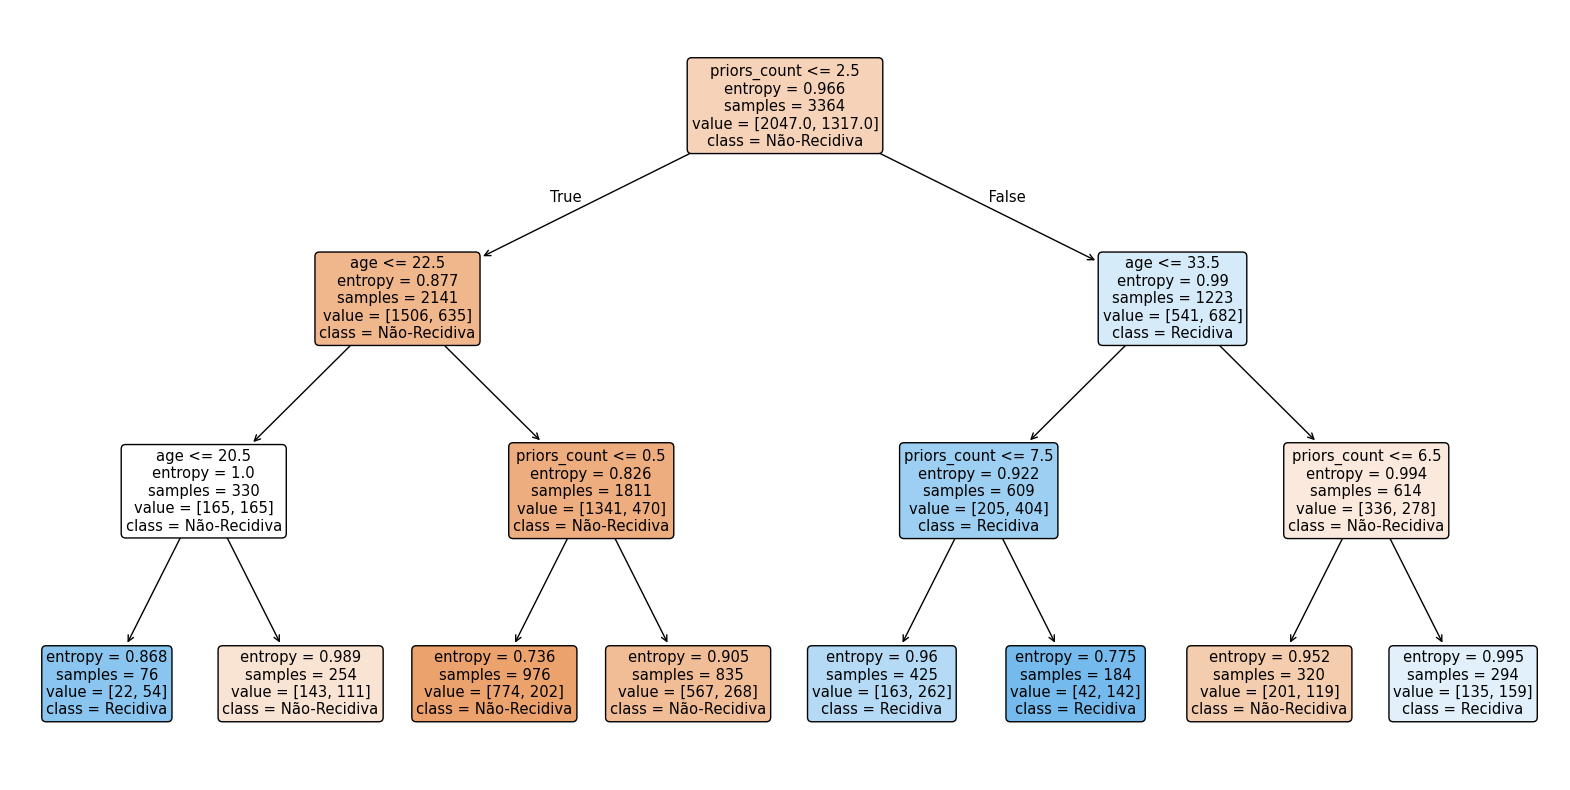

In [ ]:
from sklearn.tree import DecisionTreeClassifier
import pandas as pd

df = df_train.copy()

featureY_col = 'two_year_recid'
featureX_cols = ['age', 'priors_count']  # Ajuste com as colunas que você tem
X = df[featureX_cols]
Y = df[featureY_col]

# 1. Criar e treinar a árvore de decisão
tree = DecisionTreeClassifier(
    max_depth=3,  # Controla a complexidade da árvore
    min_samples_leaf=1,  # Evita grupos muito pequenos
    criterion='entropy'
)
tree.fit(X, Y)

# 8. Visualizar a árvore (opcional)
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

accuracy = tree.score(X, Y)
print(f"Acurácia: {accuracy}")

y = tree.predict(X)

# Calculando fairness

featureX_cols = ['race_African-American', 'race_Caucasian', 'sex_Female']
featureY_col = 'two_year_recid'

# Transformando para arrays numpy
Xf = np.asarray(df.loc[:, featureX_cols])

Prob_N0 = np.sum(np.bitwise_and(y==0, Xf[:,0] == 1))/len(y)
Prob_N1 = np.sum(np.bitwise_and(y==1, Xf[:,0] == 1))/len(y)
Prob_B0 = np.sum(np.bitwise_and(y==0, Xf[:,1] == 1))/len(y)
Prob_B1 = np.sum(np.bitwise_and(y==1, Xf[:,1] == 1))/len(y)


print(f"Reincidência pessoas negras: {Prob_N1/(Prob_N1+Prob_N0)}")
print(f"Reincidência pessoas brancas: {Prob_B1/(Prob_B1+Prob_B0)}")


plt.figure(figsize=(20,10))
plot_tree(tree,
          feature_names=X.columns,
          class_names=['Não-Recidiva', 'Recidiva'],
          filled=True,
          rounded=True)
plt.show()





**Extraindo as regras em cada folha da árvore.**

In [ ]:
# 3. Função para converter regras em condições lógicas
def extract_conditions(tree, feature_names,df):
    left = tree.tree_.children_left
    right = tree.tree_.children_right
    threshold = tree.tree_.threshold
    features = [feature_names[i] for i in tree.tree_.feature]

    conditions_df = []
    def recurse(node, current_cond):
        if left[node] != right[node]:  # nó interno
            cond = (df[features[node]] <= threshold[node])
            recurse(left[node], current_cond & cond)
            cond = (df[features[node]] > threshold[node])
            recurse(right[node], current_cond & cond)
        else:  # nó folha
            conditions_df.append(current_cond)
    recurse(0, True)

    conditions = []
    def recurse(node, current_cond):
        if left[node] != right[node]:  # nó interno
            cond = f"{features[node]} <= {threshold[node]:.2f}"
            recurse(left[node], current_cond + [cond])
            cond = f"{features[node]} > {threshold[node]:.2f}"
            recurse(right[node], current_cond + [cond])
        else:  # nó folha
            conditions.append([node, current_cond])
    recurse(0, [])

    return conditions, conditions_df


# 4. Extrair condições
conditions, conditions_df = extract_conditions(tree, list(X.columns), df)

# 5. Gerar rótulos para cada grupo
group_labels = []
for _, cond_list in enumerate(conditions):
    i = cond_list[0]
    expr = cond_list[1]
    label = f"{tree.tree_.value[i][0][1]:.2f}: \n" + " \n ".join(expr)
    group_labels.append(label)
    # print(f"\n{label}")
    # print(f" - Amostras: {tree.tree_.n_node_samples[i]}")
    # print(f" - Valor: {tree.tree_.value[i][0]}")

# 6. Aplicar ao DataFrame original
def apply_tree_groups(df, tree):
    return tree.apply(df[X.columns])

df['grupo_arvore'] = apply_tree_groups(df, tree)

# 7. Analisar os grupos criados
print("\nDistribuição dos Grupos:")
print(df['grupo_arvore'].value_counts())


Distribuição dos Grupos:
grupo_arvore
6     976
7     835
10    425
13    320
14    294
4     254
11    184
3      76
Name: count, dtype: int64


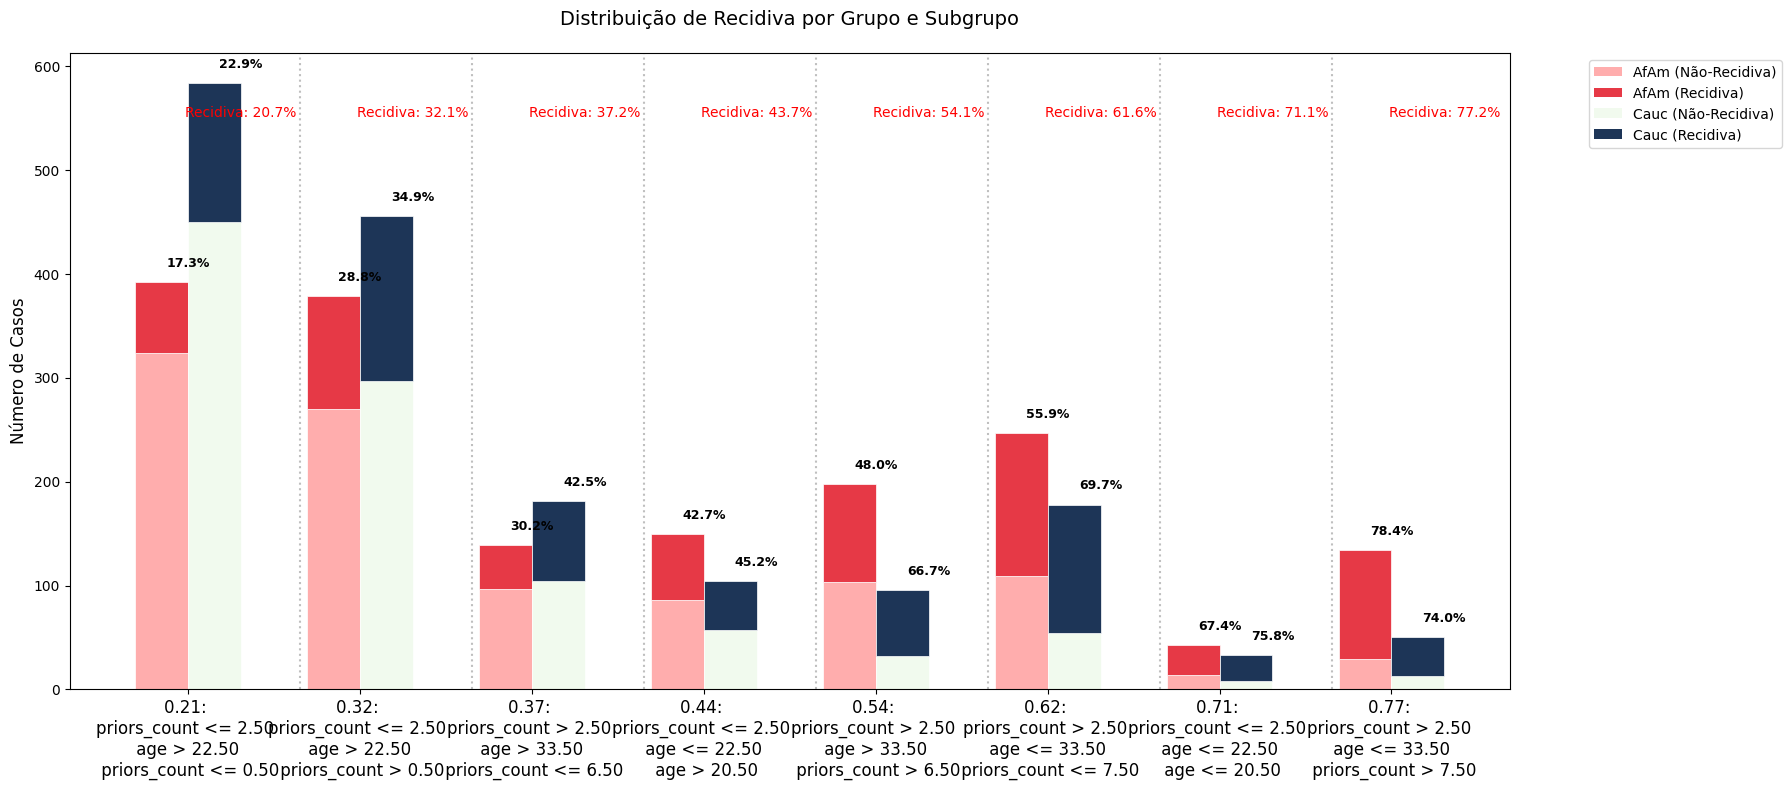

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Criando os grupos

# conditions
# group_labels

df['Grupo'] = np.select(conditions_df, group_labels, default='Outros')

# Criando subgrupos
def criar_subgrupo(row):
    if row['race_African-American'] == 1:
        return 'AfAm'
    elif row['race_Caucasian'] == 1:
        return 'Cauc'
    else:
        return 'Outros'

df['Subgrupo'] = df.apply(criar_subgrupo, axis=1)

# Calculando contagens positivas e negativas
recid_counts = df.groupby(['Grupo', 'Subgrupo', 'two_year_recid']).size().unstack(fill_value=0)
recid_counts = recid_counts.rename(columns={0: 'Não-Recidiva', 1: 'Recidiva'}).reset_index()

recid_counts_groups = df.groupby(['Grupo', 'two_year_recid']).size().unstack(fill_value=0)
recid_counts_groups = recid_counts_groups.rename(columns={0: 'Não-Recidiva', 1: 'Recidiva'}).reset_index()


# Preparando o plot
plt.figure(figsize=(18, 8))

# Definindo posições
grupos = recid_counts['Grupo'].unique()
subgrupos = recid_counts['Subgrupo'].unique()
n_grupos = len(grupos)
n_subgrupos = len(subgrupos)

# Espaçamento
group_width = 0.8  # Largura total para cada grupo
subgroup_width = group_width / n_subgrupos
gap_between_groups = 0.5  # Espaço adicional entre grupos

x = np.arange(n_grupos) * (group_width + gap_between_groups)

# Paleta de cores personalizada para cada subgrupo
subgroup_colors = {
    'AfAm': {'Recidiva': '#e63946', 'Não-Recidiva': '#ffadad'},
    'Cauc': {'Recidiva': '#1d3557', 'Não-Recidiva': '#f1faee'},
    'Outros': {'Recidiva': '#a8c686', 'Não-Recidiva': '#e9f5db'}
}

# Plotando barras empilhadas
for i, subgrupo in enumerate(subgrupos):
    if subgrupo not in subgroup_colors:
        continue  # Pula 'Outros' se existir

    subgroup_data = recid_counts[recid_counts['Subgrupo'] == subgrupo]
    pos = x + (i * subgroup_width)

    # Barras de não-recidiva (base)
    plt.bar(pos, subgroup_data['Não-Recidiva'],
            width=subgroup_width, color=subgroup_colors[subgrupo]['Não-Recidiva'],
            edgecolor='white', linewidth=0.5,
            label=f'{subgrupo} (Não)' if i == 0 else "")

    # Barras de recidiva (sobre a base)
    plt.bar(pos, subgroup_data['Recidiva'],
            width=subgroup_width, bottom=subgroup_data['Não-Recidiva'],
            color=subgroup_colors[subgrupo]['Recidiva'], edgecolor='white', linewidth=0.5,
            label=f'{subgrupo} (Sim)' if i == 0 else "")

# Ajustes estéticos
plt.xticks(x + group_width/2 - subgroup_width/2, grupos, fontsize=12)
plt.ylabel('Número de Casos', fontsize=12)
plt.title('Distribuição de Recidiva por Grupo e Subgrupo', fontsize=14, pad=20)

# Criando legendas personalizadas
from matplotlib.patches import Patch
legend_elements = []
for subgrupo in subgrupos:
    if subgrupo in subgroup_colors:
        legend_elements.append(Patch(facecolor=subgroup_colors[subgrupo]['Não-Recidiva'],
                                 label=f'{subgrupo} (Não-Recidiva)'))
        legend_elements.append(Patch(facecolor=subgroup_colors[subgrupo]['Recidiva'],
                                 label=f'{subgrupo} (Recidiva)'))

plt.legend(handles=legend_elements, bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)


# Adicionado de outro scrip
# Agregando os dados
resultados = df.groupby(['Grupo', 'Subgrupo'])['two_year_recid'].agg(['count', 'mean']).reset_index()
resultados.rename(columns={'count': 'Total', 'mean': 'Taxa_Recidiva'}, inplace=True)



# Adicionando rótulos com percentuais
for i, grupo in enumerate(grupos):
    for j, subgrupo in enumerate(subgrupos):
        data = recid_counts[(recid_counts['Grupo'] == grupo) &
                          (recid_counts['Subgrupo'] == subgrupo)]
        if not data.empty and subgrupo in subgroup_colors:
            total = data['Recidiva'].values[0] + data['Não-Recidiva'].values[0]
            recid_percent = 100 * data['Recidiva'].values[0] / total

            pos_x = x[i] + (j * subgroup_width) + subgroup_width/2

            plt.text(pos_x, total + max(recid_counts['Recidiva'] + recid_counts['Não-Recidiva']) * 0.02,
                    f'{recid_percent:.1f}%',
                    ha='center', va='bottom', fontsize=9, fontweight='bold')

    data = recid_counts_groups[(recid_counts_groups['Grupo'] == grupo)]
    total = data['Recidiva'].values[0] + data['Não-Recidiva'].values[0]
    recid_percent = data['Recidiva'].values[0] / total
    plt.text(x[i]+1.5*subgroup_width, max(resultados['Total'])*0.95,
             f'Recidiva: {recid_percent:.1%}',
             ha='center', va='center', color='red')


# Adicionando linha de separação entre grupos
for i in range(n_grupos - 1):
    sep_pos = x[i] + group_width + gap_between_groups/2
    plt.axvline(x=sep_pos, color='gray', linestyle=':', alpha=0.5)

plt.tight_layout()
plt.show()

**Aplicando as funçãoes do artigo shapley value nos dados para pegar os pesos.**

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# df = df_balanced.copy()

# 1. Protegido deve ser 1D, exemplo só raça caucasiana:
protected_attributes = df['race_Caucasian'].values

featureY_col = 'two_year_recid'
featureX_cols = ['age', 'priors_count']  # Ajuste com as colunas que você tem


X_train_np = df_train[featureX_cols].to_numpy()
X_test_np = df_test[featureX_cols].to_numpy()
y_train_np = df_train[featureY_col].to_numpy()
y_test_np = df_test[featureY_col].to_numpy()
prot_test = df_test['race_Caucasian']

# 3. Monta dicionário com o atributo protegido (1D)
protected_attributes_dict = {
    'values': prot_test,
    'privileged_protected_attribute': 1,
    'unprivileged_protected_attribute': 0,
    'favorable_label': 0,
    'unfavorable_label': 1
}

# 4. Calcula a matriz de Shapley
K = 5
SV_matrix = get_SV_matrix_numba_memory(X_train_np, X_test_np, y_train_np, y_test_np, K)

# 5. Calcula os valores SV (por exemplo, fairness ou accuracy)
sv_values = get_sv_arrays(SV_matrix, y_test_np, protected_attributes_dict, sv_type='eop')
print(sv_values)

# 6. Se quiser pesos para fairness
# svs_eop = get_sv_arrays(SV_matrix, y_test_np, protected_attributes_dict, sv_type='eop')
svs_acc, svs_eop, svs_eod_diff, svs_eod_abs = get_sv_arrays(SV_matrix, y_test_np, protected_attributes_dict, 'all')
# 7. Normaliza os pesos
weights = svs_eop

# weights[weights < 0] = 0
# weights = (weights - weights.min()) / (weights.max() - weights.min())
# weights = (weights / np.sum(weights)) * len(weights)

weights_abs = weights.copy()

weights_bin = weights.copy()
weights_bin[weights_bin <= 0] = 0
weights_bin[weights_bin > 0] = 1

weights_norm = weights.copy()
weights_norm[weights_norm < 0] = 0
weights_norm = (weights_norm - weights_norm.min()) / (weights_norm.max() - weights_norm.min())
weights_norm = (weights_norm / np.sum(weights_norm)) * len(weights_norm)

weights_normZ = weights.copy()
weights_normZ = (weights_normZ - weights_normZ.min()) / (weights_normZ.max() - weights_normZ.min())
weights_normZ = (weights_normZ / np.sum(weights_normZ)) * len(weights_normZ)



[ 1.73512148e-04  7.52979441e-05  1.64776005e-04 ... -3.67294768e-04
  9.10408780e-05 -2.69187909e-04]


**Vizualizando quais grupos da árvore de decisão são afetados (considerando os pesos)**

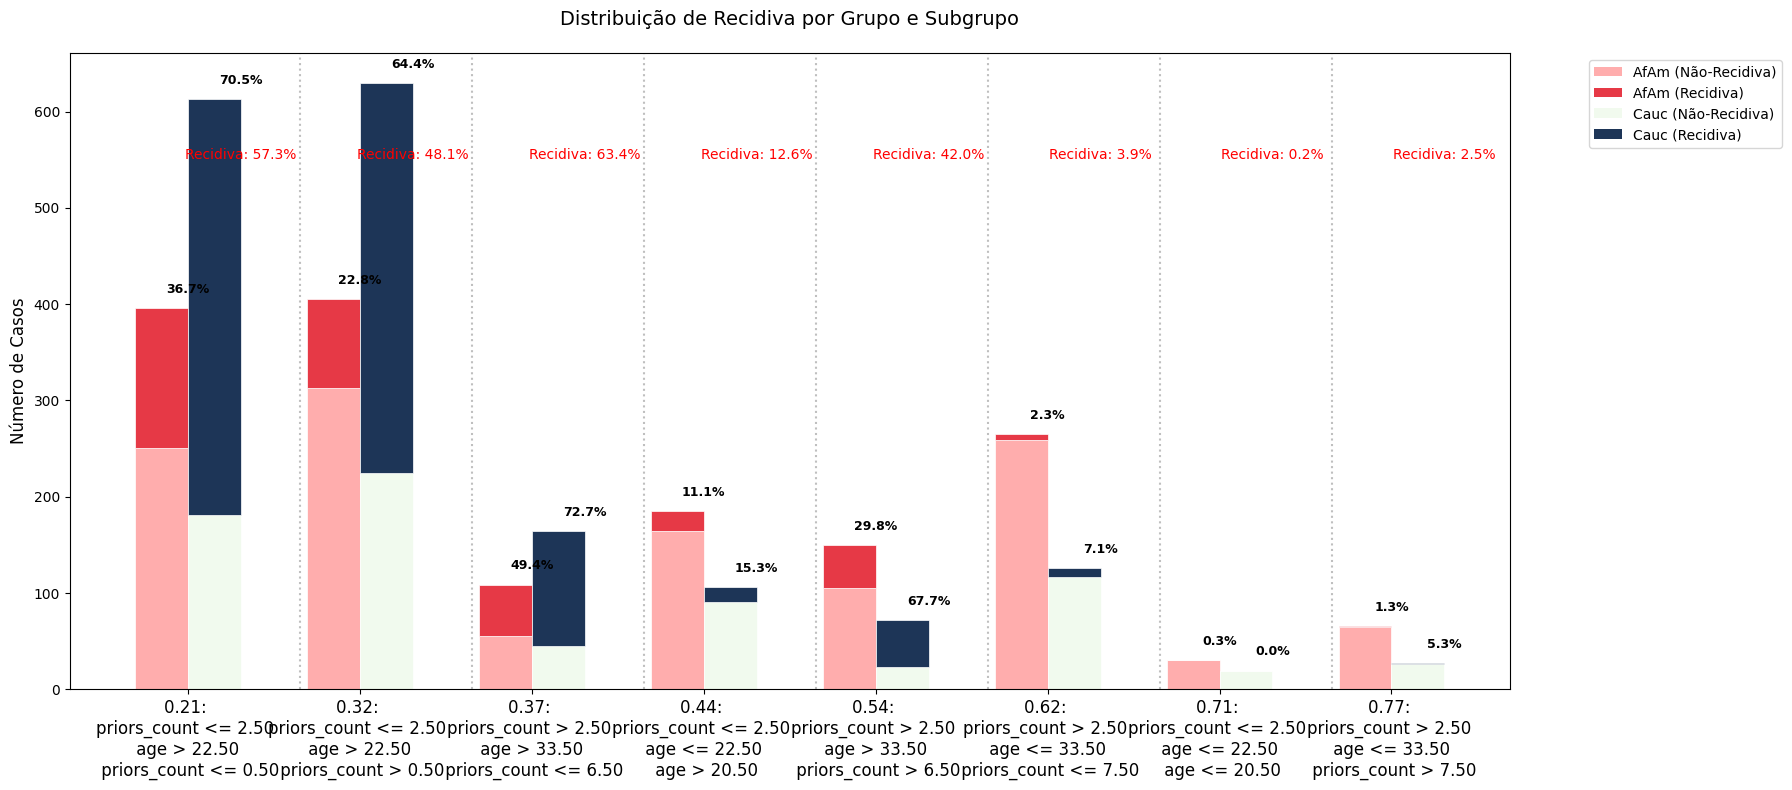

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

limiar = np.percentile(weights_abs, 25)
weights_limiar = np.where(weights_abs <= limiar, 0, 1)
weights_limiar = weights_norm

df = df_train.copy()
df['weights'] = weights_limiar

# Criando os grupos

# conditions
# group_labels

df['Grupo'] = np.select(conditions_df, group_labels, default='Outros')

# Criando subgrupos
def criar_subgrupo(row):
    if row['race_African-American'] == 1:
        return 'AfAm'
    elif row['race_Caucasian'] == 1:
        return 'Cauc'
    else:
        return 'Outros'

df['Subgrupo'] = df.apply(criar_subgrupo, axis=1)

# Calculando contagens positivas e negativas
recid_counts = df.groupby(['Grupo', 'Subgrupo', 'two_year_recid']).size().unstack(fill_value=0)
recid_counts = recid_counts.rename(columns={0: 'Não-Recidiva', 1: 'Recidiva'}).reset_index()

recid_counts_groups = df.groupby(['Grupo', 'two_year_recid']).size().unstack(fill_value=0)
recid_counts_groups = recid_counts_groups.rename(columns={0: 'Não-Recidiva', 1: 'Recidiva'}).reset_index()

recid_counts = df.groupby(['Grupo', 'Subgrupo', 'two_year_recid'])['weights'].sum().unstack(fill_value=0)
recid_counts = recid_counts.rename(columns={0: 'Não-Recidiva', 1: 'Recidiva'}).reset_index()

recid_counts_groups = df.groupby(['Grupo', 'two_year_recid'])['weights'].sum().unstack(fill_value=0)
recid_counts_groups = recid_counts_groups.rename(columns={0: 'Não-Recidiva', 1: 'Recidiva'}).reset_index()


# Preparando o plot
plt.figure(figsize=(18, 8))

# Definindo posições
grupos = recid_counts['Grupo'].unique()
subgrupos = recid_counts['Subgrupo'].unique()
n_grupos = len(grupos)
n_subgrupos = len(subgrupos)

# Espaçamento
group_width = 0.8  # Largura total para cada grupo
subgroup_width = group_width / n_subgrupos
gap_between_groups = 0.5  # Espaço adicional entre grupos

x = np.arange(n_grupos) * (group_width + gap_between_groups)

# Paleta de cores personalizada para cada subgrupo
subgroup_colors = {
    'AfAm': {'Recidiva': '#e63946', 'Não-Recidiva': '#ffadad'},
    'Cauc': {'Recidiva': '#1d3557', 'Não-Recidiva': '#f1faee'},
    'Outros': {'Recidiva': '#a8c686', 'Não-Recidiva': '#e9f5db'}
}

# Plotando barras empilhadas
for i, subgrupo in enumerate(subgrupos):
    if subgrupo not in subgroup_colors:
        continue  # Pula 'Outros' se existir

    subgroup_data = recid_counts[recid_counts['Subgrupo'] == subgrupo]
    pos = x + (i * subgroup_width)

    # Barras de não-recidiva (base)
    plt.bar(pos, subgroup_data['Não-Recidiva'],
            width=subgroup_width, color=subgroup_colors[subgrupo]['Não-Recidiva'],
            edgecolor='white', linewidth=0.5,
            label=f'{subgrupo} (Não)' if i == 0 else "")

    # Barras de recidiva (sobre a base)
    plt.bar(pos, subgroup_data['Recidiva'],
            width=subgroup_width, bottom=subgroup_data['Não-Recidiva'],
            color=subgroup_colors[subgrupo]['Recidiva'], edgecolor='white', linewidth=0.5,
            label=f'{subgrupo} (Sim)' if i == 0 else "")

# Ajustes estéticos
plt.xticks(x + group_width/2 - subgroup_width/2, grupos, fontsize=12)
plt.ylabel('Número de Casos', fontsize=12)
plt.title('Distribuição de Recidiva por Grupo e Subgrupo', fontsize=14, pad=20)

# Criando legendas personalizadas
from matplotlib.patches import Patch
legend_elements = []
for subgrupo in subgrupos:
    if subgrupo in subgroup_colors:
        legend_elements.append(Patch(facecolor=subgroup_colors[subgrupo]['Não-Recidiva'],
                                 label=f'{subgrupo} (Não-Recidiva)'))
        legend_elements.append(Patch(facecolor=subgroup_colors[subgrupo]['Recidiva'],
                                 label=f'{subgrupo} (Recidiva)'))

plt.legend(handles=legend_elements, bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)


# Adicionado de outro scrip
# Agregando os dados
resultados = df.groupby(['Grupo', 'Subgrupo'])['two_year_recid'].agg(['count', 'mean']).reset_index()
resultados.rename(columns={'count': 'Total', 'mean': 'Taxa_Recidiva'}, inplace=True)



# Adicionando rótulos com percentuais
for i, grupo in enumerate(grupos):
    for j, subgrupo in enumerate(subgrupos):
        data = recid_counts[(recid_counts['Grupo'] == grupo) &
                          (recid_counts['Subgrupo'] == subgrupo)]
        if not data.empty and subgrupo in subgroup_colors:
            total = data['Recidiva'].values[0] + data['Não-Recidiva'].values[0]
            recid_percent = 100 * data['Recidiva'].values[0] / total

            pos_x = x[i] + (j * subgroup_width) + subgroup_width/2

            plt.text(pos_x, total + max(recid_counts['Recidiva'] + recid_counts['Não-Recidiva']) * 0.02,
                    f'{recid_percent:.1f}%',
                    ha='center', va='bottom', fontsize=9, fontweight='bold')

    data = recid_counts_groups[(recid_counts_groups['Grupo'] == grupo)]
    total = data['Recidiva'].values[0] + data['Não-Recidiva'].values[0]
    recid_percent = data['Recidiva'].values[0] / total
    plt.text(x[i]+1.5*subgroup_width, max(resultados['Total'])*0.95,
             f'Recidiva: {recid_percent:.1%}',
             ha='center', va='center', color='red')


# Adicionando linha de separação entre grupos
for i in range(n_grupos - 1):
    sep_pos = x[i] + group_width + gap_between_groups/2
    plt.axvline(x=sep_pos, color='gray', linestyle=':', alpha=0.5)

plt.tight_layout()
plt.show()

**Treina árvore com os pesos**

Acurácia: 0.6840071343638525
Reincidência pessoas negras: 0.31272294887039237
Reincidência pessoas brancas: 0.17122473246135553


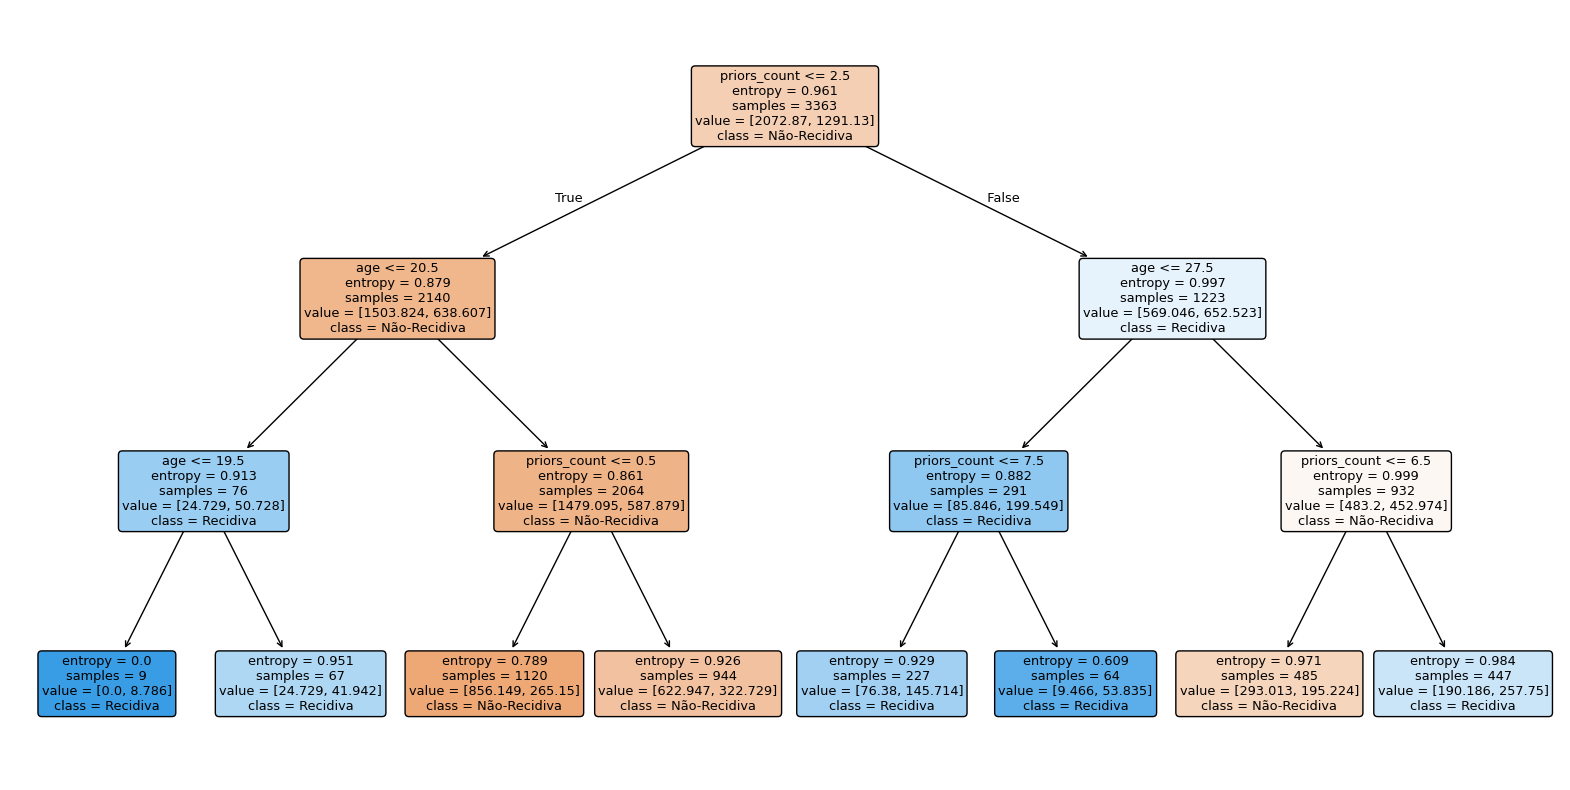

In [ ]:
from sklearn.tree import DecisionTreeClassifier
import pandas as pd

limiar = np.percentile(weights_abs, 20)
weights_limiar = np.where(weights_abs <= limiar, 0, 1)
weights_limiar = weights_normZ

df = df_train.copy()

featureY_col = 'two_year_recid'
featureX_cols = ['age', 'priors_count']  # Ajuste com as colunas que você tem
X = df[featureX_cols]
Y = df[featureY_col]

# 1. Criar e treinar a árvore de decisão
tree = DecisionTreeClassifier(
    max_depth=3,  # Controla a complexidade da árvore
    min_samples_leaf=1,  # Evita grupos muito pequenos
    criterion='entropy'
)
tree.fit(X, Y, sample_weight=weights_limiar)
# tree.fit(X, Y)

# 8. Visualizar a árvore (opcional)
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

accuracy = tree.score(X, Y)
print(f"Acurácia: {accuracy}")

y = tree.predict(X)

# Calculando fairness

featureX_cols = ['race_African-American', 'race_Caucasian', 'sex_Female']
featureY_col = 'two_year_recid'

# Transformando para arrays numpy
Xf = np.asarray(df.loc[:, featureX_cols])

Prob_N0 = np.sum(np.bitwise_and(y==0, Xf[:,0] == 1))/len(y)
Prob_N1 = np.sum(np.bitwise_and(y==1, Xf[:,0] == 1))/len(y)
Prob_B0 = np.sum(np.bitwise_and(y==0, Xf[:,1] == 1))/len(y)
Prob_B1 = np.sum(np.bitwise_and(y==1, Xf[:,1] == 1))/len(y)


print(f"Reincidência pessoas negras: {Prob_N1/(Prob_N1+Prob_N0)}")
print(f"Reincidência pessoas brancas: {Prob_B1/(Prob_B1+Prob_B0)}")


plt.figure(figsize=(20,10))
plot_tree(tree,
          feature_names=X.columns,
          class_names=['Não-Recidiva', 'Recidiva'],
          filled=True,
          rounded=True)
plt.show()



